# Train ADAGE models on RNAseq data

### Georgia Doing 2021

This notebook walks through the training of an RNAseq-based ADAGE model as a continuation of analyses from last year (2021_06_eADAGE_adapt/seqADAGE).

Since then we have downloaded a new compendium of RNAseq data and aligned it to the PAO1 and PA14 reference genomes using prokarytoic-optimized parameters.
(https://github.com/hoganlab-dartmouth/pa-seq-compendia)

The main objectives are to train models, take a first look and save the models for further analysis on forthcoming notebooks
1. Load compendia
2. Train and save models
3. Visualize first-look plots

### 0. Setup

In [1]:
import run_count_autoencoder
import run_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imp import reload
import Adage
import TiedWeightsEncoder

In [13]:
# for dev purposes, while updating run_model.py need to reload
sns.reset_orig()
reload(run_count_autoencoder)
reload(run_model)
reload(Adage)
reload(TiedWeightsEncoder)

<module 'TiedWeightsEncoder' from '/home/georgia/Dropbox (Hogan Lab)/Digital_notebook/2021_04_23_seqADAGE/seqADAGE/Py/TiedWeightsEncoder.py'>

### 1. Load Compendia

In [2]:
array_comp = pd.read_csv(open('../data_files/train_set_normalized.csv', "rb"),index_col=0)
print(array_comp.shape)

(5549, 950)


In [3]:
seq_comp_floor = pd.read_csv(open('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_floor.csv', "rb"),index_col=0)
print(seq_comp_floor.shape)

(5563, 2767)


In [4]:
seq_comp = pd.read_csv(open('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01.csv', "rb"),index_col=0)
print(seq_comp.shape)

(5563, 2766)


<AxesSubplot:ylabel='Density'>

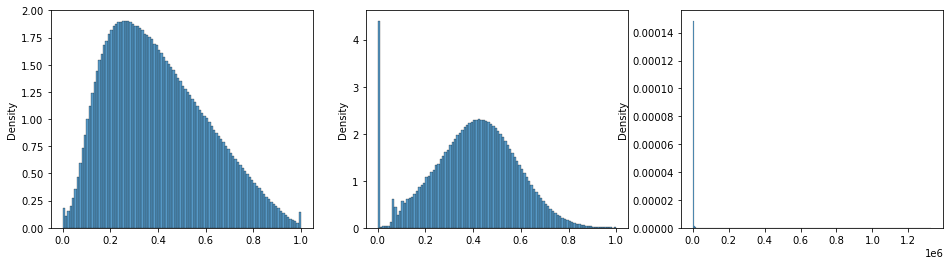

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16 ,4))
sns.histplot(array_comp.to_numpy().flatten(),binwidth=0.01, stat='density',ax=ax1)
sns.histplot(seq_comp.to_numpy().flatten(),binwidth=0.01,stat='density',ax=ax2)
sns.histplot(seq_comp_floor.to_numpy().flatten(), bins=200,stat='density',ax=ax3)

### 2. Train Models

In [15]:
m = run_model.run_model('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01.csv',lr=.5,seed=660,kl1=0,kl2=0,act = 'sigmoid', tied = True, epochs=50, init='glorot_uniform', batch_size=10,v=1)


Epoch 1/50
249/249 [==============================] - 6s 24ms/step - loss: 0.6593 - val_loss: 0.6608
Epoch 2/50
249/249 [==============================] - 6s 23ms/step - loss: 0.6332 - val_loss: 0.6606
Epoch 3/50
249/249 [==============================] - 5s 21ms/step - loss: 0.6322 - val_loss: 0.6620
Epoch 4/50
249/249 [==============================] - 5s 19ms/step - loss: 0.6289 - val_loss: 0.6654
Epoch 5/50
249/249 [==============================] - 5s 20ms/step - loss: 0.6271 - val_loss: 0.6676
Epoch 6/50
249/249 [==============================] - 5s 21ms/step - loss: 0.6256 - val_loss: 0.6675
Epoch 7/50
249/249 [==============================] - 5s 21ms/step - loss: 0.6247 - val_loss: 0.6669
Epoch 8/50
249/249 [==============================] - 5s 20ms/step - loss: 0.6247 - val_loss: 0.6660
Epoch 9/50
249/249 [==============================] - 4s 18ms/step - loss: 0.6219 - val_loss: 0.6650
Epoch 10/50
249/249 [==============================] - 5s 19ms/step - loss: 0.6221 - val_lo

In [6]:
mc = run_count_autoencoder.run_count_autoencoder('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm.csv',lr=.01,seed=660,kl1=1e-10,kl2=1e-1, act = 'relu', tied = True, epochs=50, init='glorot_uniform', batch_size=10)
ma = run_model.run_model('../data_files/train_set_normalized.csv',lr=.5,seed=660,kl1=0,kl2=0,act = 'sigmoid', tied = True, epochs=50, init='glorot_uniform', batch_size=10,v=0)
m = run_model.run_model('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01.csv',lr=.5,seed=660,kl1=0,kl2=0,act = 'sigmoid', tied = True, epochs=50, init='glorot_uniform', batch_size=10,v=0)

tf_adage = Adage.Adage(ma.autoencoder, ma.history, ma.compendium)
tf_weights = np.array(pd.read_csv('../outputs/ADAGE_OG_weights.csv', header = None))
tf_cost = pd.read_csv('../outputs/ADAGE_OG_cost_log.csv')
tf_adage.weights = tf_weights
tf_adage.loss = tf_cost['cost']
tf_adage.val_loss = tf_cost['cost']
tf_adage.set_hwg_cutoff(2.5).shape

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/50
249/249 [==============================] - 16s 60ms/step - loss: 4503.6629 - val_loss: 2897.3113
Epoch 2/50
249/249 [==============================] - 15s 59ms/step - loss: 4469.8022 - val_loss: 2896.3811
Epoch 3/50
249/249 [==============================] - 14s 55ms/step - loss: 4467.4140 - val_loss: 2896.7932
Epoch 4/50
249/249 [==============================] - 14s 58ms/step - loss: 

(5549, 600)

### 3. First-look plots

#### Training Loss Curves and Node Weight Distributions

In [17]:
weights_temp = np.array(pd.read_csv('../outputs/weights/data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01_seed:660_kl1:0_kl2:0_act:sigmoid_init:glorot_uniform_ep:50_tied:True_batch:10_lr:0.5_en_weights_da.csv', header = None))
print(weights_temp.shape)

(5563, 300)


t_adage
k_adage
k_da
k_dca


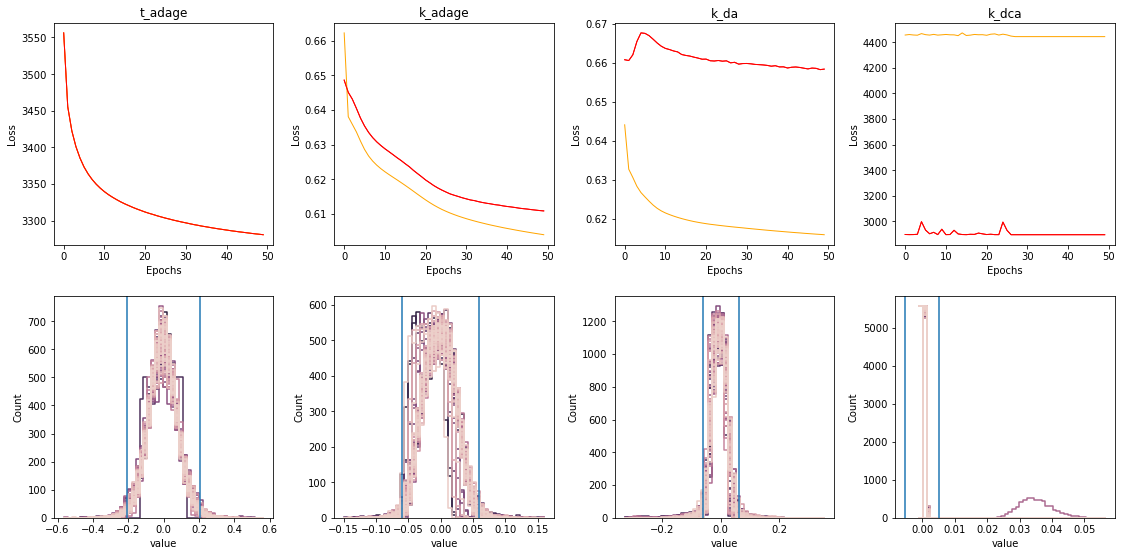

In [16]:
model_dict = {
    "t_adage": tf_adage,
    "k_adage": ma,
    "k_da" : m,
    "k_dca": mc
}
fig, ax = plt.subplots(2, 4,figsize=(16 ,8))
fig.tight_layout(pad=3.0)

eps = 50
i=0
for mo in model_dict.keys():
    print(mo)
    model_temp = model_dict[mo]
    ax[0,i].plot(list(range(0,eps)), model_temp.val_loss[0:eps], linewidth=1, markersize=2, color = 'red')
    ax[0,i].plot(list(range(0,eps)), model_temp.loss[0:eps], linewidth=1, markersize=2, color = 'orange')
    ax[0,i].plot(list(range(0,eps)), model_temp.val_loss[0:eps], linewidth=1, markersize=2, color = 'red')
    ax[0,i].set(title = mo, xlabel = 'Epochs', ylabel = 'Loss')
    ax[0,i].set(title = mo)
    
    sns.histplot(pd.melt(pd.DataFrame(model_temp.weights[:,0:300])),
             x='value', hue='variable', legend=False,element='step',fill=False,
             ax=ax[1,i], bins=50)
    ax[1,i].axvline(x = np.std(model_temp.weights)*2.5)
    ax[1,i].axvline(x = np.std(model_temp.weights)*-2.5)
    i = i+1

### Wrap-up thoughts

These models do not appear to be training, even that trained on array data. This is frustrating since last year this same code trained models on both the array and refine.bio rnaseq compendia OK. Since then the only changes have been those involved in the update of python and keras/tensorflow. 


These models seem to be training faster than the ones last year and I wonder if that is an indication of a change in the datatypes, loss function or optimizer. 

In [338]:
model_dict = {
    "t_adage": tf_adage,
    "k_adage": ma,
    "k_da" : m,
    "k_dca": mc
}

plimo=10
for mo in model_dict:
    model_dict[mo].set_hwg_cutoff(2.5)
    model_dict[mo].set_op('../node_interpretation/operons_format.txt')
    x = ((model_dict[mo].ops_ps > plimo).sum(0) > 0).sum()
    y = ((model_dict[mo].ops_ps > plimo).sum(1) > 0).sum()
    print(mo + ": " + str(x) + " sigs w/ ops , " + str(y) + " ops w/ sigs")

t_adage: 210 sigs w/ ops , 416 ops w/ sigs
k_adage: 204 sigs w/ ops , 436 ops w/ sigs
k_da: 159 sigs w/ ops , 448 ops w/ sigs
k_dca: 10 sigs w/ ops , 300 ops w/ sigs
